## INFO212 Assignment2 T22

In [122]:
# altair installation
!pip install seaborn

In [37]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import altair as alt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

### Data Collection  
Request:  
- Download JSON data files containing economic indicators from reputable sources (e.g. such as the World Bank or IMF).  
- Ensure the data spans at least 5 years for multiple countries. 

In [7]:
# 定义查询的国家和指标
countries = ["CN", "BR", "JP", "CA", "NP"]
indicators = {
    "GDP": "NY.GDP.MKTP.CD",
    "Unemployment": "SL.UEM.TOTL.ZS",
    "Inflation": "FP.CPI.TOTL",
    "Tariff rate": "TM.TAX.MANF.SM.AR.ZS",
    "GDP growth": "NY.GDP.MKTP.KD.ZG"
}
years = range(1980, 2019 + 1)
base_url = "http://api.worldbank.org/v2/country/{}/indicator/{}?date={}:{}&format=json&per_page=100"

# 获取数据并合并成一个JSON文件
data = {}
for indicator_name, indicator_code in indicators.items():
    data[indicator_name] = {}
    for country in countries:
        response = requests.get(base_url.format(country, indicator_code, years[0], years[-1]))
        if response.status_code == 200:
            result = response.json()
            if len(result) > 1:
                data[indicator_name][country] = result[1]
        else:
            print(f"Error fetching data for {country} - {indicator_name}: {response.status_code}")

# 保存数据到JSON文件
with open("world_bank_data.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data has been saved to world_bank_data.json")


Data has been saved to world_bank_data.json


In [8]:
with open("world_bank_data.json", "r") as f:
    data = json.load(f)

## Data Preparation  
Request:  
- If required, load the JSON files into Pandas DataFrames.     
- Clean the data by handling missing values, duplicates, and incorrect data 
types. 

In [9]:
# 国家名称映射字典
country_names = {"CN": "China", "BR": "Brazil", "JP": "Japan", "CA": "Canada", "NP": "Nepal"}

def create_indicator_dataframe(data, indicator):
    records = [(country_names[country_code], int(entry['date']), entry['value']) for country_code, values in data[indicator].items() for entry in values]
    df = pd.DataFrame(records, columns=['country', 'date', indicator])
    df_pivot = df.pivot(index='date', columns='country', values=indicator)
    clear_Nan(df_pivot)
    return df_pivot


def clear_Nan(df,value=0):
    Nan_mask = df.isna()
    df[Nan_mask] = value
    return Nan_mask

In [54]:
# 创建GDP、Unemployment、Inflation的DataFrame
gdp_df = create_indicator_dataframe(data, "GDP")
unemployment_df = create_indicator_dataframe(data, "Unemployment")
inflation_df = create_indicator_dataframe(data, "Inflation")
tariff_df = create_indicator_dataframe(data, "Tariff rate")
gdp_growth_df = create_indicator_dataframe(data, "GDP growth")

indicators = ["GDP", "Unemployment", "Inflation", "Tariff rate", "GDP growth"]

dfs = dict(zip(indicators, [gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]))
    
def display_dfs(df, title):
    df_list = {}
    for _df, _title in zip(df, title):
        df_list[_title] = _df.style.set_caption(f"{_title} DataFrame")

    # 将每个样式化的DataFrame转换为HTML并打印
    for _title, _styled_df in df_list.items():
        display(HTML(_styled_df.to_html()))


# 调用display_dfs函数来一次性输出所有DataFrame
display_dfs([gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df], indicators)

## Data Analysis
- Perform exploratory data analysis (EDA) to understand the datasets. 
- Calculate summary statistics and identify trends over time for each 
indicator. 

In [55]:
dfs_summary = {}

# 对于每个 indicator 的 dataframe 我们都对其进行describe分析
for (name,df) in dfs.items():
    dfs_summary[name] = df.describe()
display_dfs(dfs_summary.values(), dfs_summary.keys())

In [21]:
# 为了进行对每个国家各自的相关性分析，我们需要获取一个国家dataframe，其中包含所有的indicator
def create_country_dataframe(dfs, country):
    out_df = pd.DataFrame()
    indicators = dfs.keys()

    for df in dfs.values():
        out_df = pd.concat((out_df,df[country]),axis=1) 
    out_df.columns = indicators
    return out_df

country_dfs = {}
for country in country_names.values():
    country_dfs[country] = create_country_dataframe(dfs,country)

# 为每个国家的所有参数之间创造相关性矩阵
df_corrs = {}
for (name,df) in country_dfs.items():
    df_corr = df.corr()
    df_corrs[name] = df_corr
    df_corr = df.style.set_caption(name)
    display(HTML(df_corr.to_html()))

## Data Visualization 

- Create visualizations to represent the trends and patterns discovered 
during EDA. 
- Use line plots, bar charts, and scatter plots to compare different 
economic indicators across countries. 
- Employ Seaborn’s advanced features like facet grids or pair plots to 
visualize multi-dimensional data.

Explore treads of different indicators across countries

In [56]:
# 绘制altair的折线图函数
def draw_line_chart(name,df):
    df = df.reset_index()
    long_df = pd.melt(df, id_vars=['date'],var_name='Country', value_name=f'{name}')
    chart = alt.Chart(long_df).mark_line(point=True).encode(
        x='date:O', 
        y=f'{name}:Q',
        color='Country:N',
        tooltip=['Country', 'date', f'{name}']
    ).properties(
        title=f'{name} of Five Countries',
        width=600,
        height=400
    )
    return chart

# 揭示不同国家在每个indicator下的趋势
selected_indicator = ["Unemployment", "Inflation", "Tariff rate", "GDP growth"]
charts = [draw_line_chart(name,dfs[name])for name in selected_indicator]

# 创造网格
grid = alt.vconcat(
    alt.hconcat(*charts[:2]), 
    alt.hconcat(*charts[2:])
).resolve_scale(
    x='shared',
    y='shared'
)

grid.display()

alt.VConcatChart(...)

In [ ]:
# 对于这些折线图我们可以得出以下结论：
# 1. 对于失业率来说我们可以看到在1999-2004年间各国的失业率都比较高，而随后大部分国家的失业率都在稳步下降
# 2. 对于通胀率，我们可以发现各国的通胀率从1980年开始就在不断地上升，而其中尼泊尔的通胀率上升最为严重，这可能是由于国内动荡以及外部环境的不稳定
# 3. 我们可以发现各国的关税率在1980年以来都在逐步下降，这可以说明世界贸易的不断进展与开放
# 4. GDP增长率反应了一个国家的发展速度，我们可以发现各国的GDP都在某一均值附近来回波动，其中，中国的GDP增速尤为明显

Explore relations between indicators

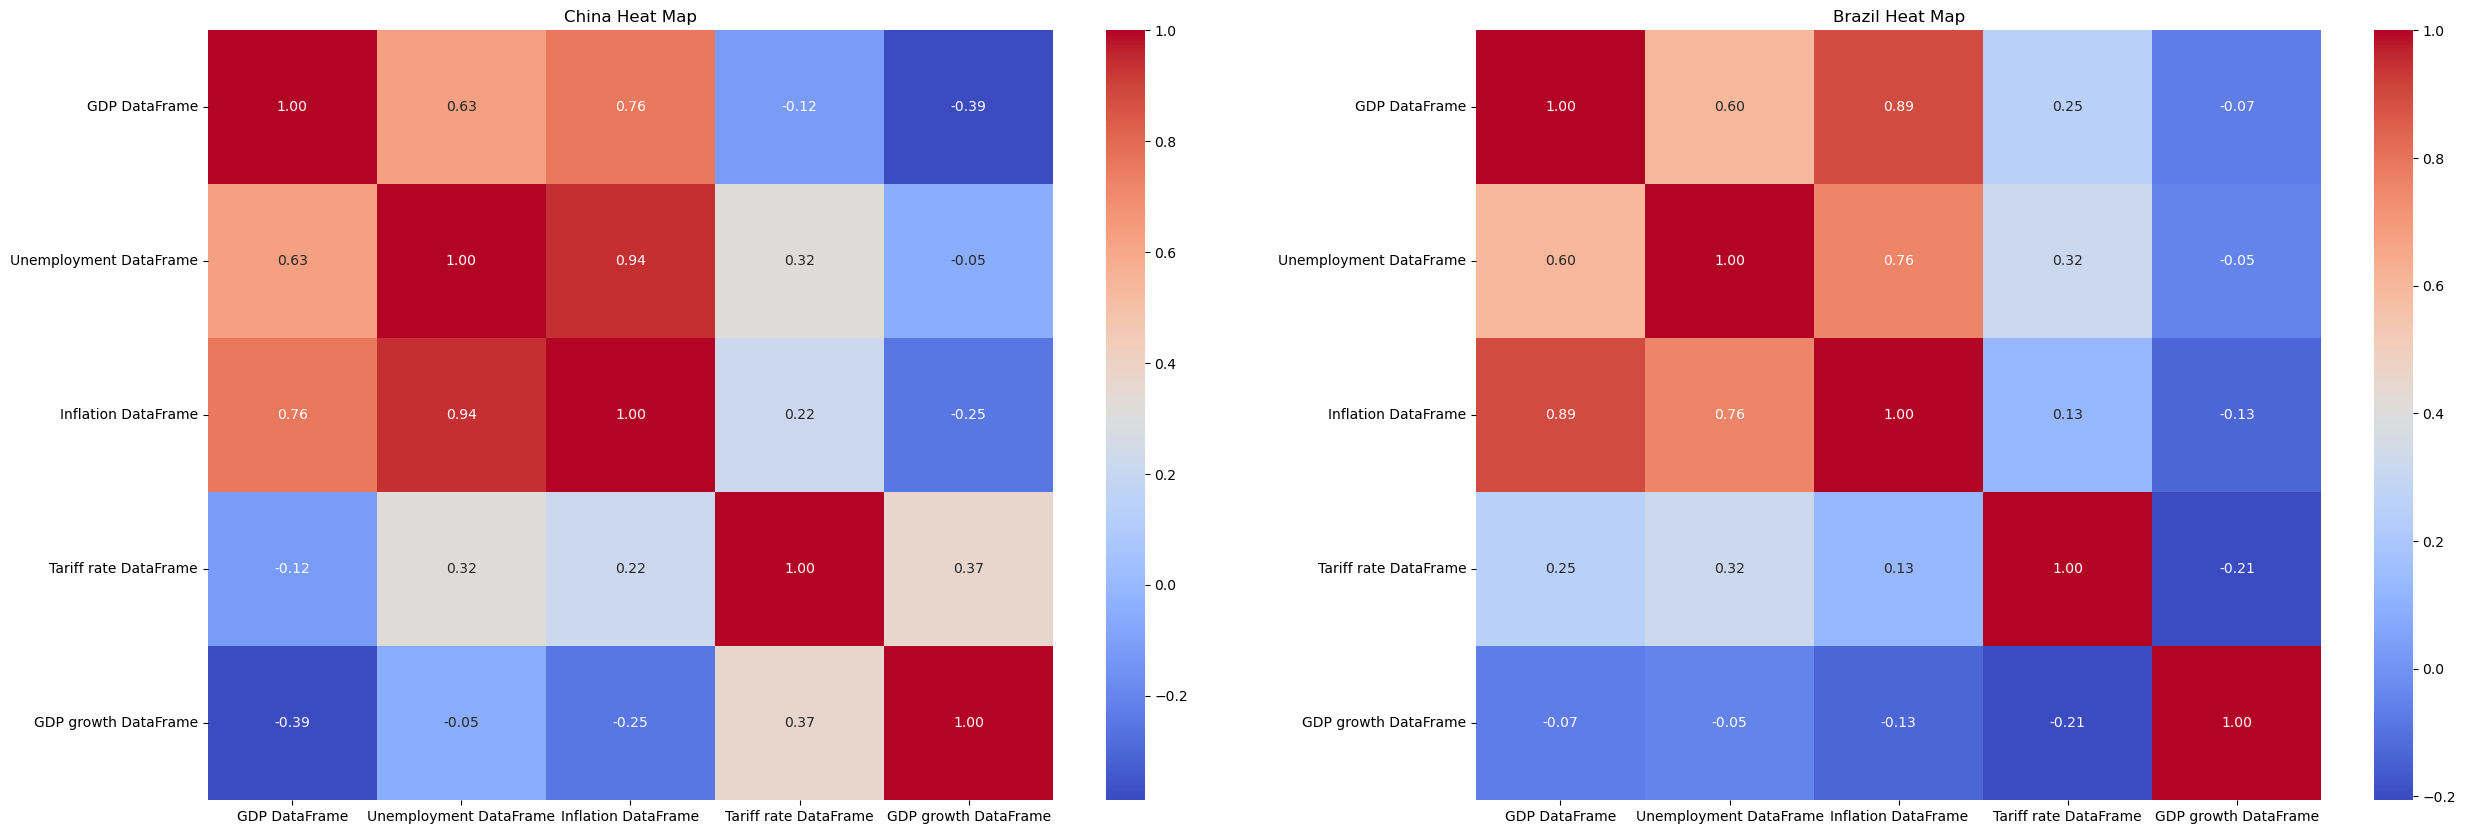

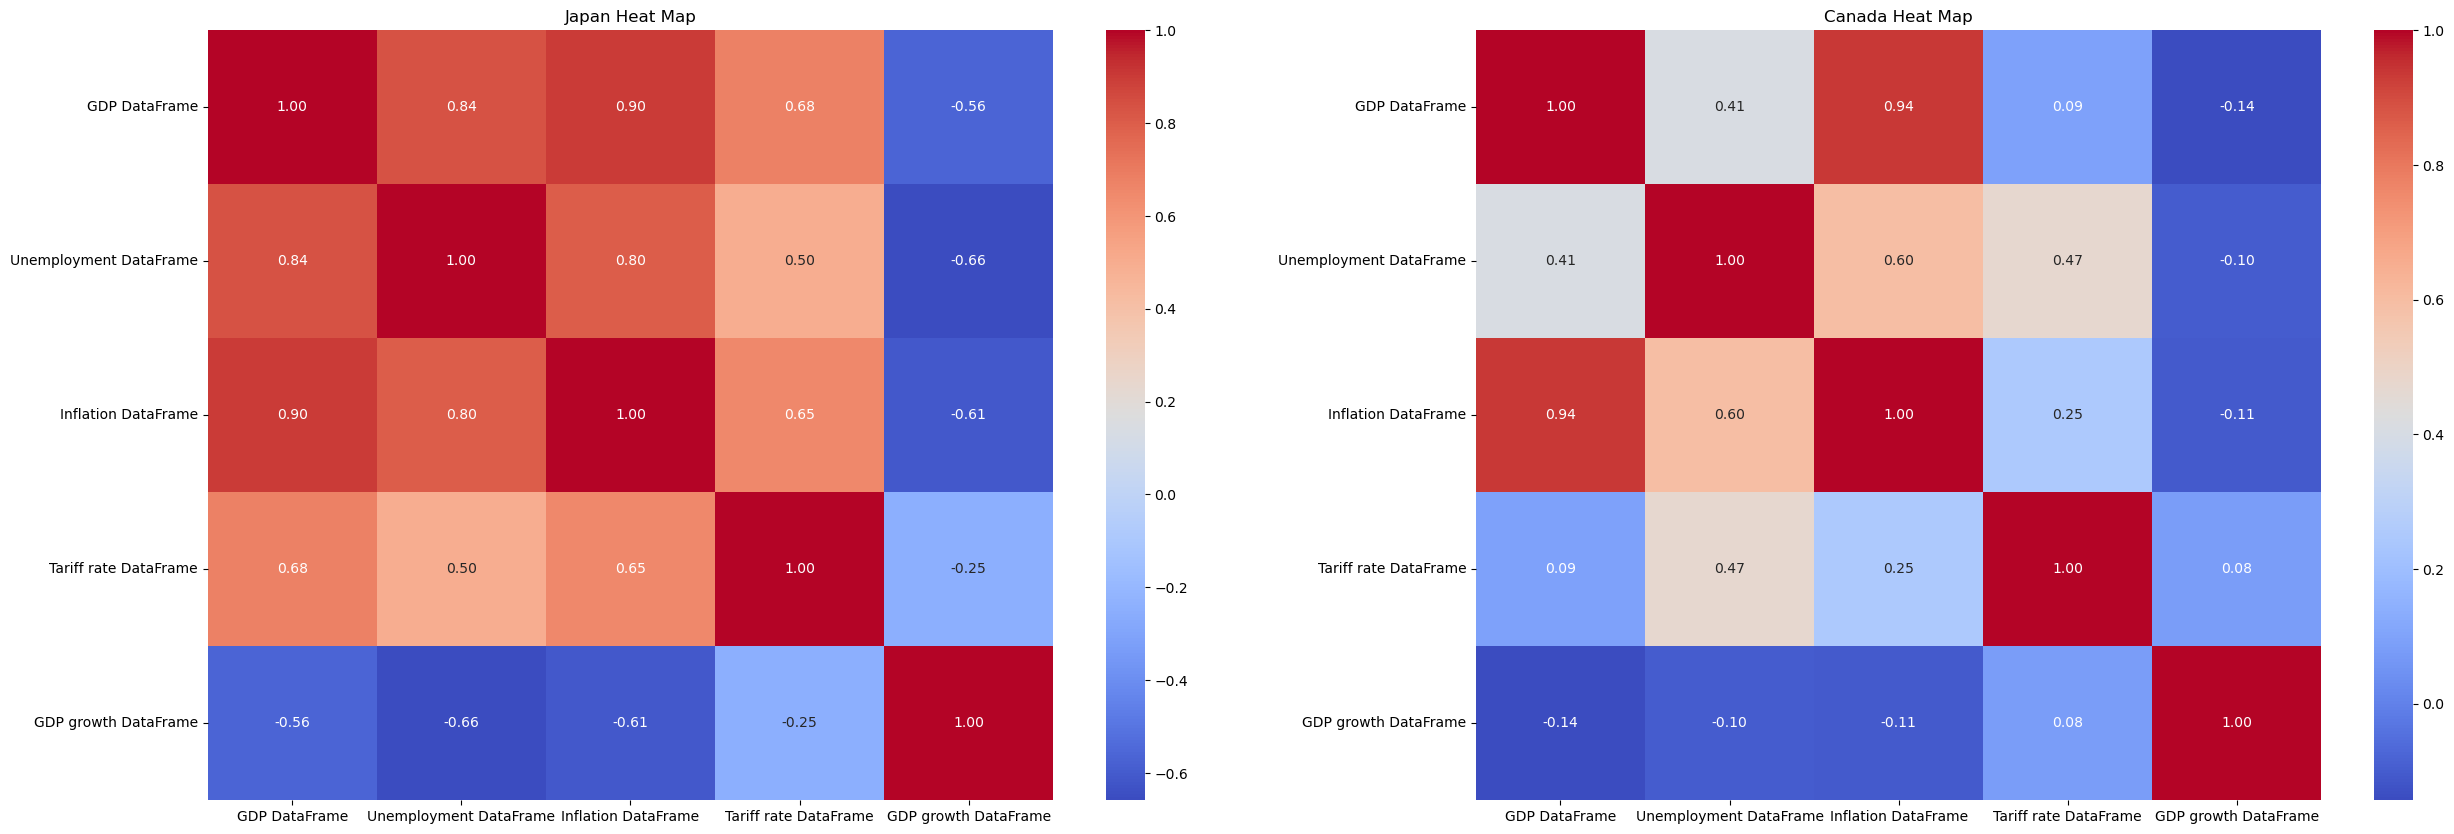

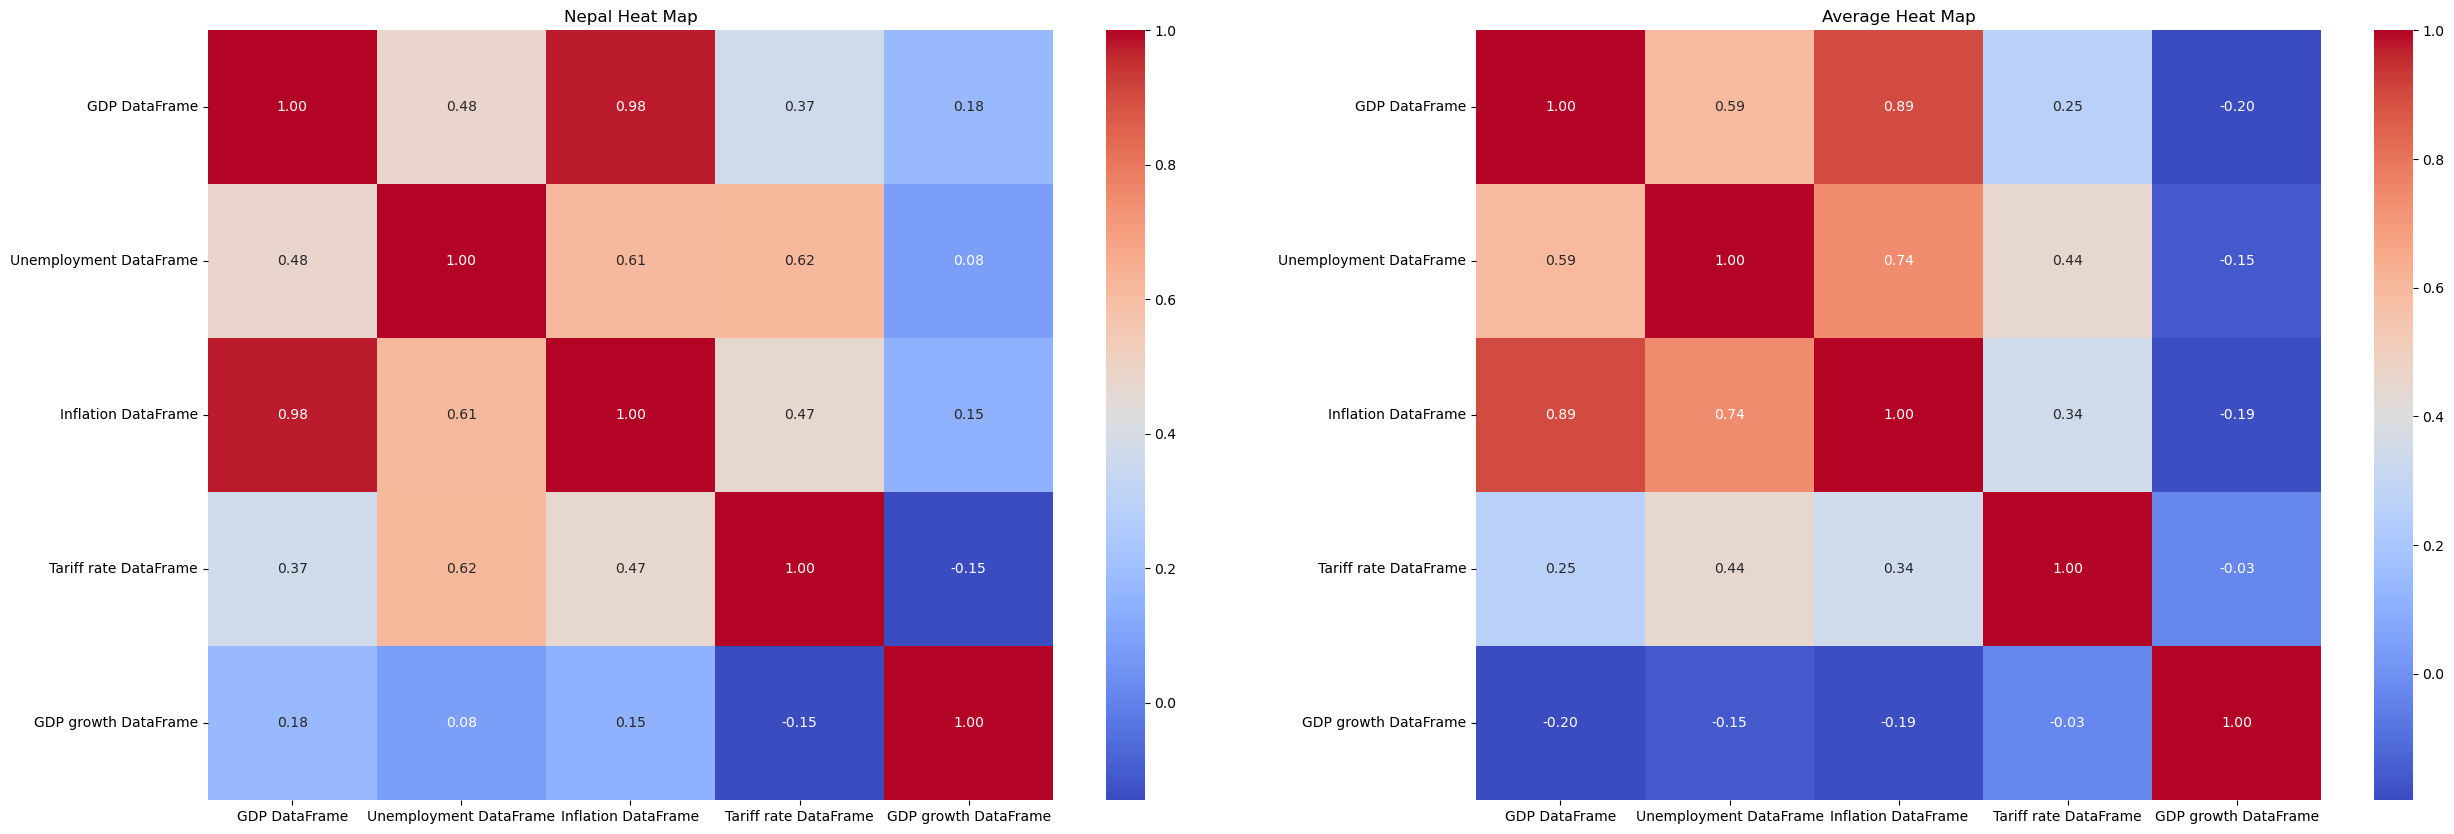

In [45]:
# 对于每个国家，我们都用heatmap来探究indicator之间的相关性

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['China'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'China Heat Map')

sns.heatmap(df_corrs['Brazil'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Brazil Heat Map')

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['Japan'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'Japan Heat Map')

sns.heatmap(df_corrs['Canada'], ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Canada Heat Map')

fig, axs = plt.subplots(1, 2, figsize=(30, 10)) 
sns.heatmap(df_corrs['Nepal'], ax=axs[0], cmap='coolwarm', annot=True, fmt=".2f")
axs[0].set_title(f'Nepal Heat Map')

# 为了更好地揭示总体的趋势，我们计算了所有国家的相关性矩阵的平均值，并展示在这个图中
mean_corr_matrix = pd.DataFrame(np.mean([df_corr.values for df_corr in df_corrs.values()], axis=0))
mean_corr_matrix.index = dfs.keys()
mean_corr_matrix.columns = dfs.keys()
sns.heatmap(mean_corr_matrix, ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f")
axs[1].set_title(f'Average Heat Map')


plt.show()

In [ ]:
# 各国的indicator之间的相关性差异没有特别大，他们都反应了相同的趋势
# 因此我们可以直接观察平均的heatmap
# 观察发现了几个重要的点
# 一是GDP的总量与通胀水平密切相关，这也揭示了GDP不直接反应一个国家的繁荣程度
# 同时，高失业率也与通胀水平密切相关，这有可能是在国家经济状态不好时高失业与高通胀的同时发生
# 有一个很蹊跷的地方是，高失业与GDP总量有着0.6左右的相关性，这意味着失业越多GDP越高，这点难以解释
# 另一点是关税与失业率有一定的正相关，这点有可能是国内经济状态下行导致失业率上升同时关税增加

Pair Plot of GDP DataFrame


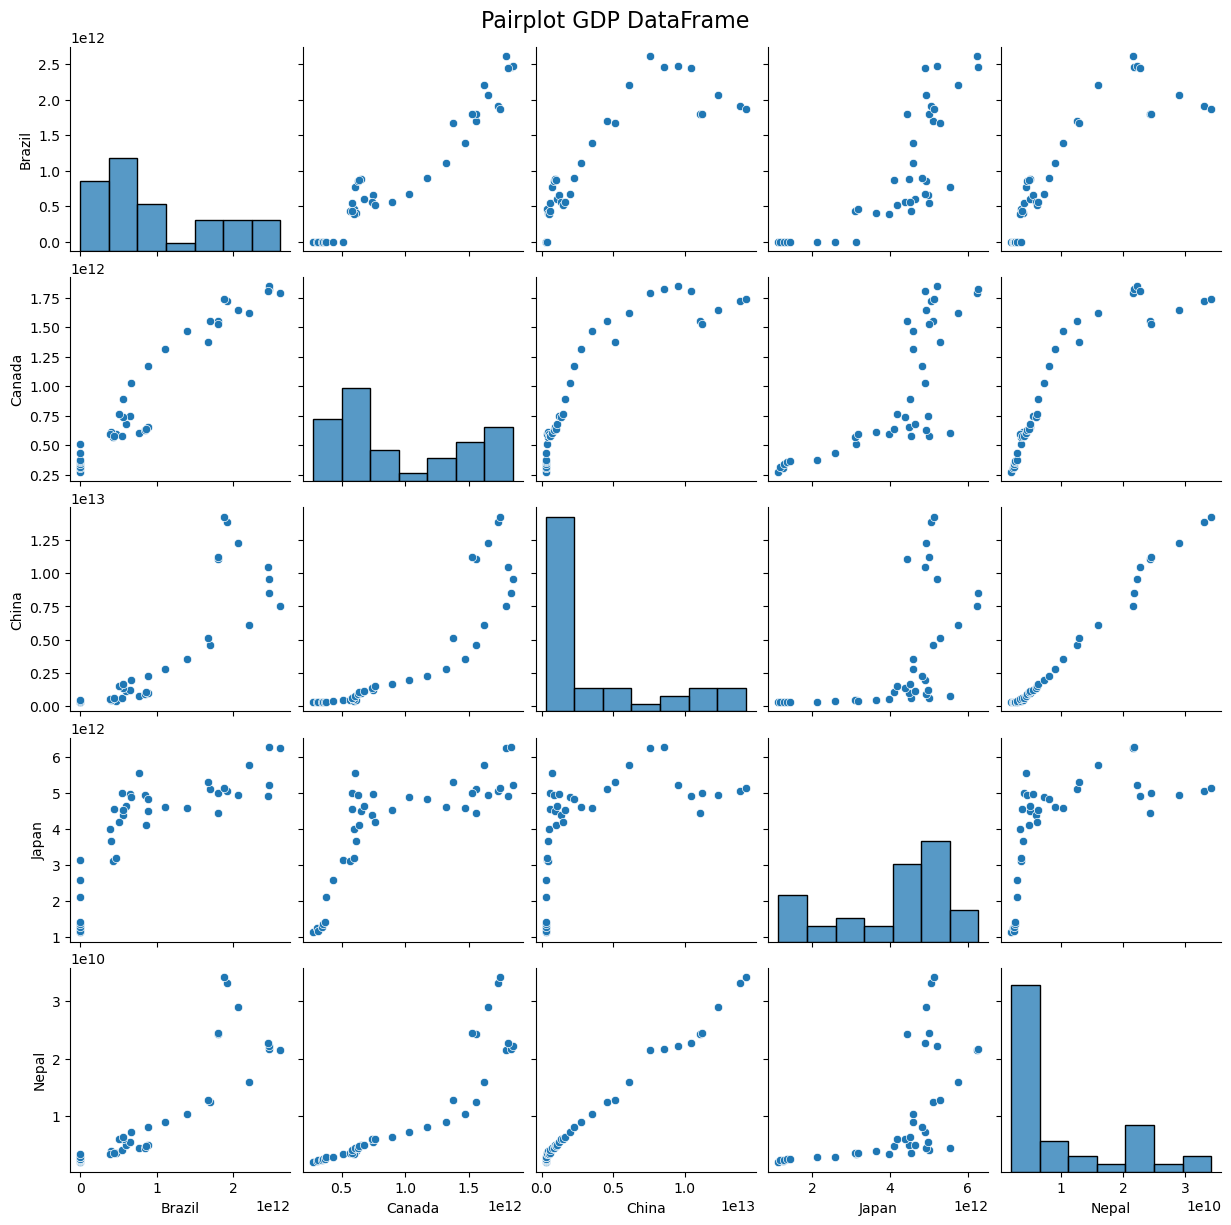

Pair Plot of Unemployment DataFrame


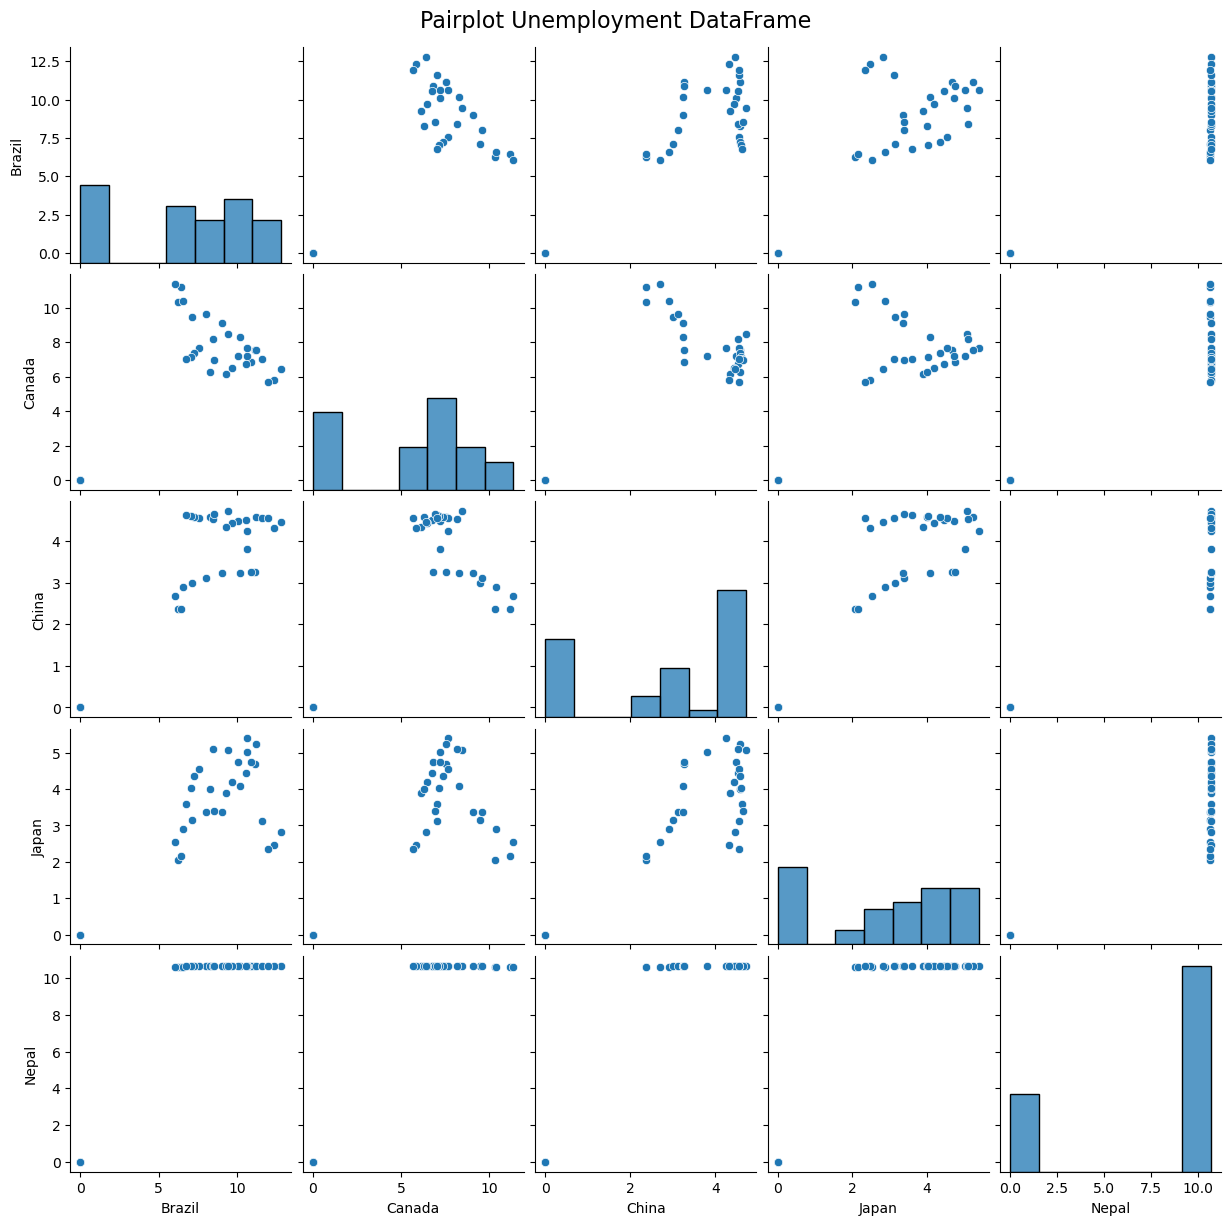

Pair Plot of Inflation DataFrame


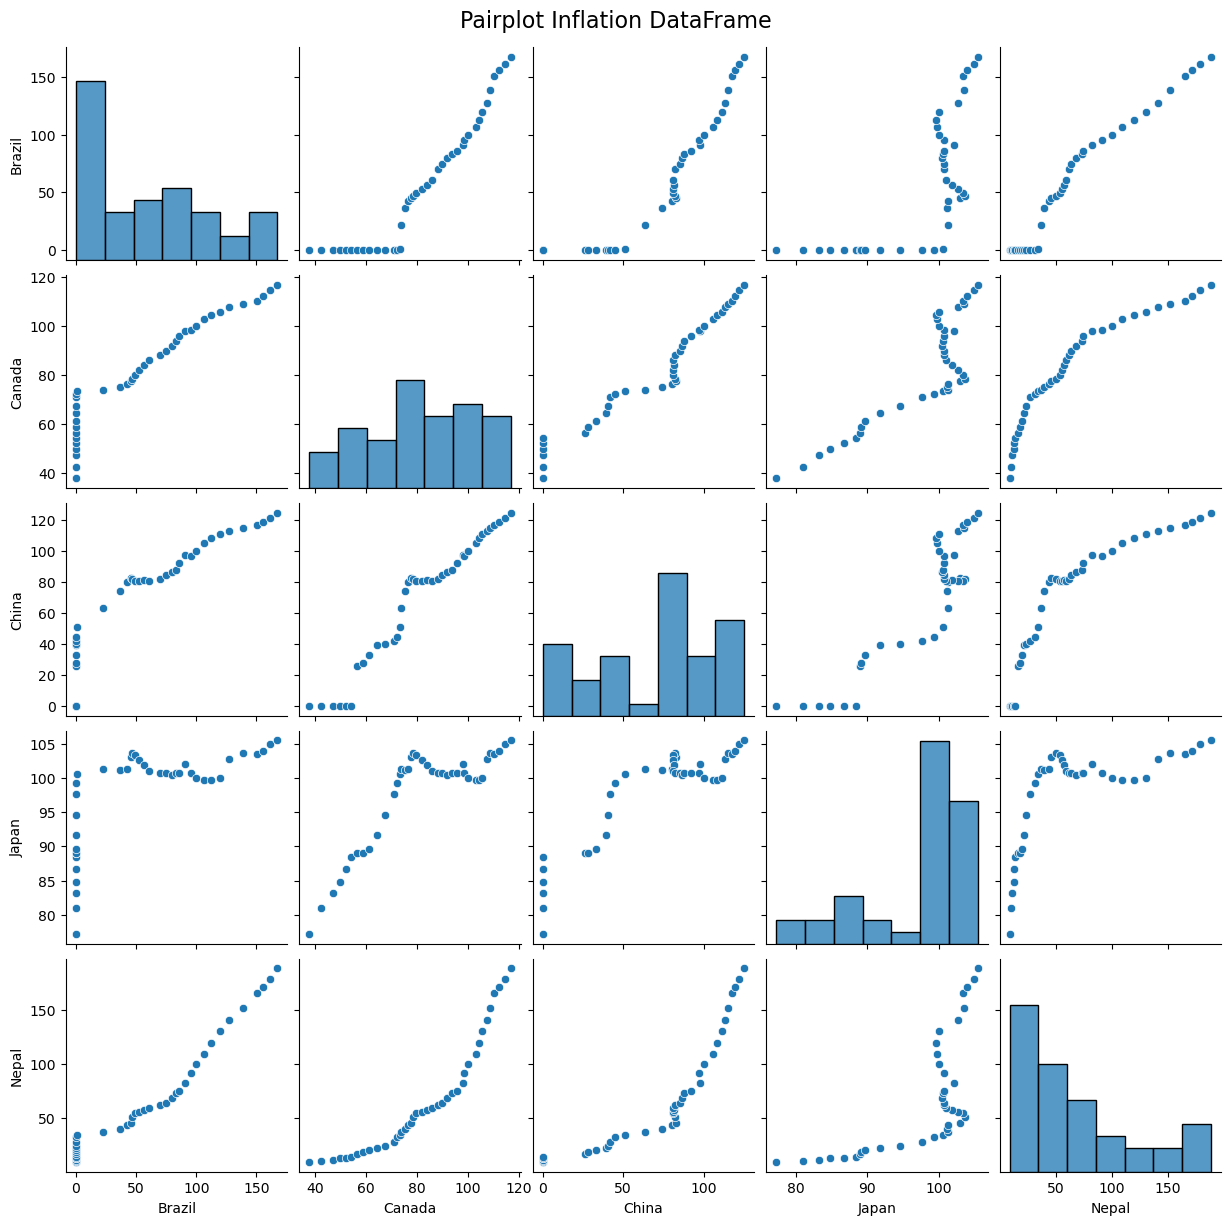

Pair Plot of Tariff rate DataFrame


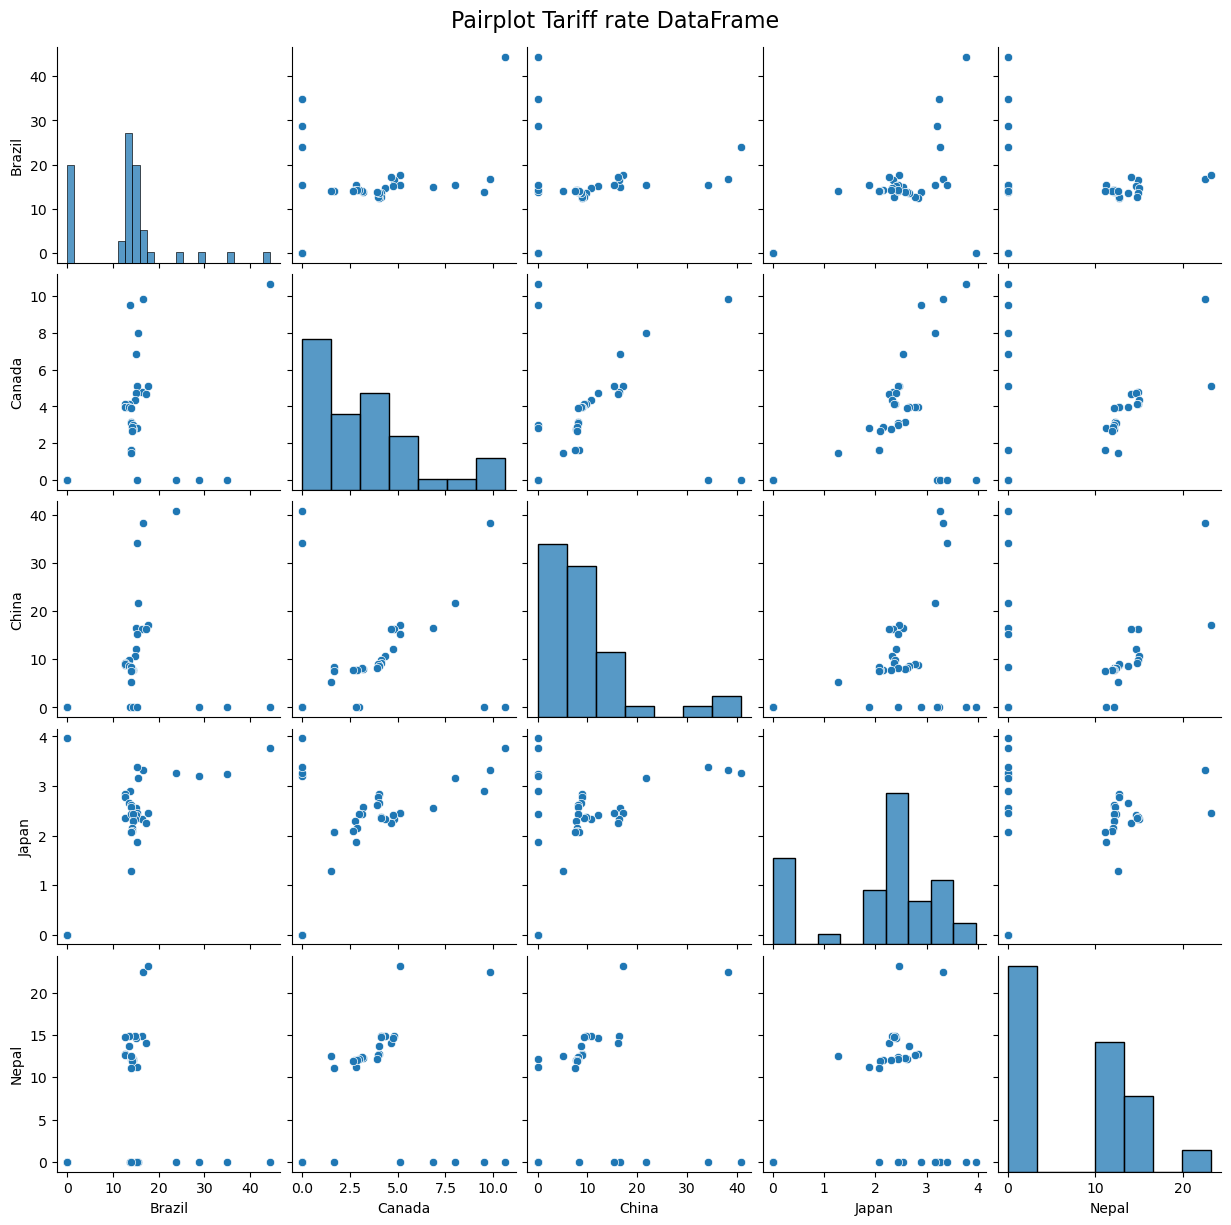

Pair Plot of GDP growth DataFrame


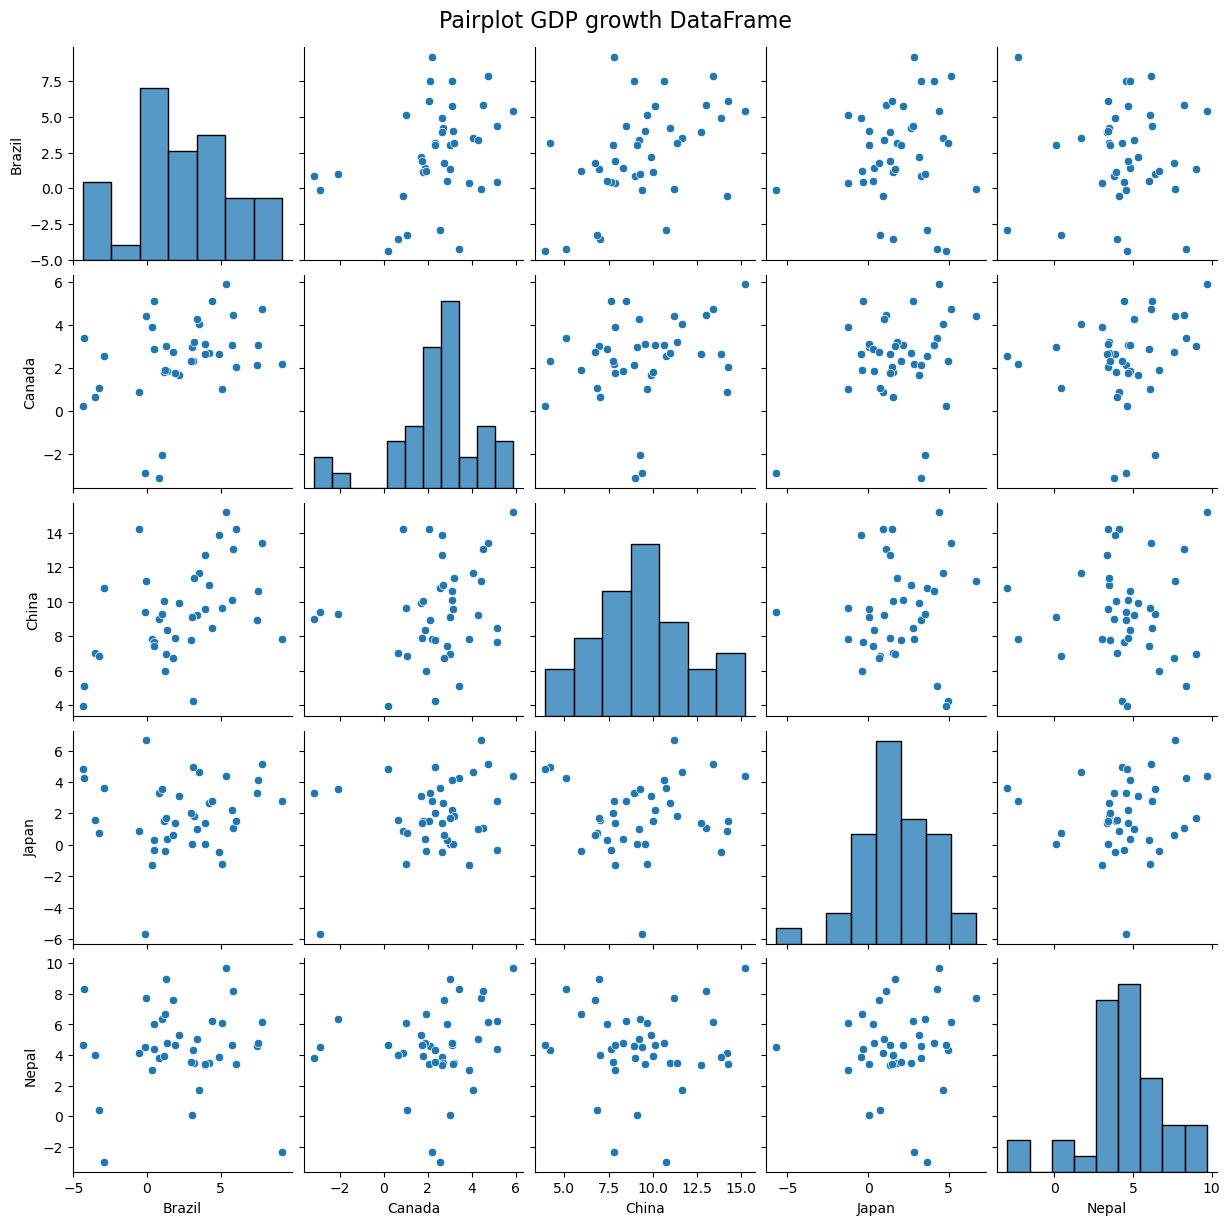

In [38]:
# 此处我们使用pairplot来展示不同国家在某一个indicator中对其他国家的影响状况
for (name, df), ax in zip(dfs.items(), axs.flatten()):
    pairplot = sns.pairplot(df)

    plt.subplots_adjust(top=0.95)
    pairplot.fig.suptitle(f'Pairplot of {name}', fontsize=16)

    plt.show()

In [ ]:
# 通过上面几个表我们可以观察到，国家之间在大部分的指标上都没有表现出相关性
# 但是有两个指标表现出了强的正相关性，一个是GDP，另一个是关税
# GDP的正相关性在一定程度上可以反应国家之间的协同关系以及贸易往来，拿中国举例，中国与尼泊尔的GDP表现出强烈的正相关性，这表明了两国之间的贸易往来较为频繁，或者是两国都处在快速增长时期
# 在关税水平上，大部分国家都表现出了正相关，这很大程度上反应了世界的经济趋势以及环境

### Interpretation 
- Interpret the visualizations to draw meaningful conclusions about the 
economic health of the countries. 
- Discuss any correlations or anomalies found between different 
economic indicators.